<a href="https://colab.research.google.com/github/ouhenio/stylegan3-projector/blob/add-colab-notebook/StyleGAN3%2BInversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@markdown #**Setup libraries and functions** 🏗️🛠️

!pip install --upgrade torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install --upgrade https://download.pytorch.org/whl/nightly/cu111/torch-1.11.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl https://download.pytorch.org/whl/nightly/cu111/torchvision-0.12.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl
!git clone https://github.com/NVlabs/stylegan3
!pip install einops ninja
!pip install wget 

import sys
sys.path.append('./stylegan3')

import io
import os, time
import pickle
import shutil
import numpy as np
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import copy
import imageio
import unicodedata
import re
from PIL import Image
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from google.colab import files
from time import perf_counter
from stylegan3.dnnlib.util import open_url
import wget


device = torch.device('cuda:0')

# Load VGG16 feature detector.
url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
with open_url(url) as f:
    vgg16 = torch.jit.load(f).eval().to(device)
print('Using device:', device, file=sys.stderr)

def fetch_model(url_or_path):
    if "drive.google" in url_or_path:
      if "18MOpwTMJsl_Z17q-wQVnaRLCUFZYSNkj" in url_or_path: 
        basename = "wikiart-1024-stylegan3-t-17.2Mimg.pkl"
      elif "14UGDDOusZ9TMb-pOrF0PAjMGVWLSAii1" in url_or_path:
        basename = "lhq-256-stylegan3-t-25Mimg.pkl"
    else:
        basename = os.path.basename(url_or_path)
    if os.path.exists(basename):
        return basename
    else:
        if "drive.google" not in url_or_path:
          !wget -c '{url_or_path}'
        else:
          path_id = url_or_path.split("id=")[-1]
          !gdown --id '{path_id}'
        return basename

def download_img(img_url):
    try:
        return wget.download(img_url,out="input.jpg")
    except:
        return

# Projector

def project(
    G,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    num_steps                  = 1000,
    w_avg_samples              = -1,
    initial_learning_rate      = 0.1,
    initial_noise_factor       = 0.05,
    lr_rampdown_length         = 0.25,
    lr_rampup_length           = 0.05,
    noise_ramp_length          = 0.75,
    regularize_noise_weight    = 1e5,
    verbose                    = False,
    device: torch.device
):

    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)

    def logprint(*args):
        if verbose:
            print(*args)

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore

    # Compute w stats.
    if w_avg_samples > 0:
      logprint(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
      z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)
    else:
      seed = np.random.randint(0, 2**32 - 1)
      z_samples = np.random.RandomState(seed).randn(1, G.z_dim)
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Features for target image.
    target_images = target.unsqueeze(0).to(device).to(torch.float32)
    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    target_features = vgg16(target_images, resize_images=False, return_lpips=True)

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)

    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth images from opt_w.
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
        synth_images = G.synthesis(ws, noise_mode='const')

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * (255/2)
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
        dist = (target_features - synth_features).square().sum()

        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        loss = dist + reg_loss * regularize_noise_weight

        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        logprint(f'step {step+1:>4d}/{num_steps}: dist {dist:<4.2f} loss {float(loss):<5.2f}')

        # Save projected W for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()

    return w_out.repeat([1, G.mapping.num_ws, 1])

def get_perceptual_loss(synth_image, target_features):
    # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
    synth_image = (synth_image + 1) * (255/2)
    if synth_image.shape[2] > 256:
        synth_image = F.interpolate(synth_image, size=(256, 256), mode='area')

    # Features for synth images.
    synth_features = vgg16(synth_image, resize_images=False, return_lpips=True)
    return (target_features - synth_features).square().sum()

def get_target_features(target):
    target_images = target.unsqueeze(0).to(device).to(torch.float32)
    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    return vgg16(target_images, resize_images=False, return_lpips=True)

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.6 MB/s eta 0:12:17tcmalloc: large alloc 1147494400 bytes == 0x562df9dd0000 @  0x7f9d27581615 0x562dc11fa17c 0x562dc12da47a 0x562dc11fcf9d 0x562dc12eed4d 0x562dc1270ec8 0x562dc126ba2e 0x562dc11fe88a 0x562dc1270d30 0x562dc126ba2e 0x562dc11fe88a 0x562dc126d719 0x562dc12efb76 0x562dc126cd95 0x562dc12efb76 0x562dc126cd95 0x562dc12efb76 0x562dc126cd95 0x562dc11fece9 0x562dc1242579 0x562dc11fd902 0x562dc1270c4d 0x562dc126ba2e 0x562dc11fe88a 0x562dc126d719 0x562dc126ba2e 0x562dc11fe88a 0x562dc126c8f6 0x562dc11fe7aa 0x562dc126cb4f 0x562dc126ba2e
     |████████████████▌               | 1055.7 MB 1.5 MB/s eta 0:11:20tcmalloc: large alloc 1434370048 bytes == 0x562e3e426000 @  0x7f9d27581615 0x562dc11fa17c 0x562dc12da47a 0x562dc11fcf9d 0x562dc12eed4d 0x562dc1270ec8 0x562dc126ba2e 0x562dc11fe88a 0x562dc1270d30 0x562dc126ba2e 0x562dc11fe88a 0x562dc126d719 0x562dc12efb76 0x562dc126cd

Using device: cuda:0


In [2]:
#@markdown #**Model selection** 🎭


#@markdown There are 4 pre-trained options to play with:
#@markdown - FFHQ: Trained with human faces.
#@markdown - MetFaces: Trained with paintings/portraits of human faces.
#@markdown - AFHQv2: Trained with animal faces.
#@markdown - Cosplay: Trained by [l4rz](https://twitter.com/l4rz) with cosplayer's faces.
#@markdown - Wikiart: Trained by [Justin Pinkney](https://www.justinpinkney.com/) with the Wikiart 1024 dataset.
#@markdown - Landscapes: Trained by [Justin Pinkney](https://www.justinpinkney.com/) with the LHQ dataset.


#@markdown **Run this cell again if you change the model**.

#@markdown ---

base_url = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/"

Model = 'FFHQ' #@param ["FFHQ", "MetFaces", "AFHQv2", "cosplay", "Wikiart", "Landscapes"]

#@markdown ---

model_name = {
    "FFHQ": base_url + "stylegan3-t-ffhqu-1024x1024.pkl",
    "MetFaces": base_url + "stylegan3-r-metfacesu-1024x1024.pkl",
    "AFHQv2": base_url + "stylegan3-t-afhqv2-512x512.pkl",
    "cosplay": "https://l4rz.net/cosplayface-snapshot-stylegan3t-008000.pkl",
    "Wikiart": "https://archive.org/download/wikiart-1024-stylegan3-t-17.2Mimg/wikiart-1024-stylegan3-t-17.2Mimg.pkl",
    "Landscapes": "https://archive.org/download/lhq-256-stylegan3-t-25Mimg/lhq-256-stylegan3-t-25Mimg.pkl"
}

network_url = model_name[Model]

with open(fetch_model(network_url), 'rb') as fp:
  G = pickle.load(fp)['G_ema'].to(device)

zs = torch.randn([10000, G.mapping.z_dim], device=device)
w_stds = G.mapping(zs, None).std(0)

--2022-03-29 23:33:34--  https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhqu-1024x1024.pkl
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 44.238.198.213, 52.34.39.39
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|44.238.198.213|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://prod-model-registry-ngc-bucket.s3.us-west-2.amazonaws.com/org/nvidia/team/research/models/stylegan3/versions/1/files/stylegan3-t-ffhqu-1024x1024.pkl?response-content-disposition=attachment%3B%20filename%3D%22stylegan3-t-ffhqu-1024x1024.pkl%22&response-content-type=application%2Foctet-stream&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEFgaCXVzLXdlc3QtMiJHMEUCIQD9%2FSVT0MY1CknxyqNqp03KOK%2BQ8K9NX5YebvmihapGXgIgfUAH6kWGFIy0vNVTXqObVVr1xoUw0yBOW8HlcHQ22ewqgwQI4f%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FARAEGgw3ODkzNjMxMzUwMjciDGcP0VLW0PK1xnDGkyrXA8P7UsiumIFLOvZf%2Fb765pXmty5vyovE30DCeIM9yHAY9C4U0S73VWp%2BOidfhExek%2Blrmfgbvpa0jDQ7I5K2tIxUtxT8VDjl

In [8]:
#@markdown #**Parameters** ✍️
#@markdown ---
#@markdown `target_image_filename`: URL or an uploaded file

target_image_filename = "https://static.wikia.nocookie.net/fiveworldadventures/images/5/5f/Monkey_D._Luffy.png"#@param {type:"string"}
steps = 500#@param {type:"number"}

if target_image_filename.lower().startswith("http"):
  target_image_filename = download_img(target_image_filename)
target_pil = Image.open(target_image_filename).convert('RGB')
w, h = target_pil.size
s = min(w, h)
target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
target_pil = target_pil.resize((G.img_resolution, G.img_resolution), Image.LANCZOS)
target_uint8 = np.array(target_pil, dtype=np.uint8)
target_tensor = torch.tensor(target_uint8.transpose([2, 0, 1]), device=device)

input.jpg


Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


  0%|          | 0/1500 [00:00<?, ?it/s]

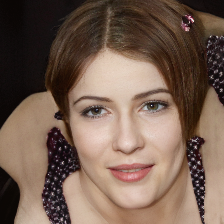

image 0/1500 | loss: 0.757778525352478


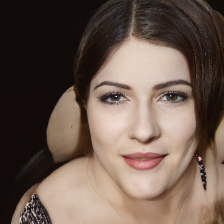

image 10/1500 | loss: 0.6700921058654785


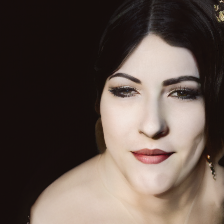

image 20/1500 | loss: 0.6474301218986511


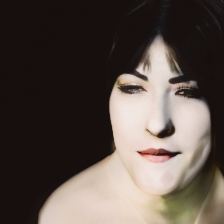

image 30/1500 | loss: 0.6162023544311523


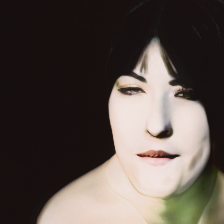

image 40/1500 | loss: 0.6030164957046509


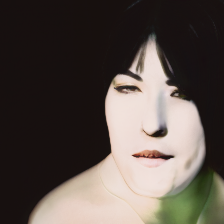

image 50/1500 | loss: 0.6091619729995728


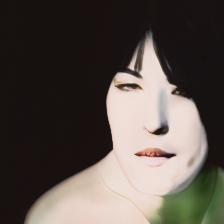

image 60/1500 | loss: 0.6041175127029419


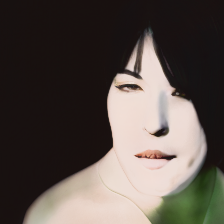

image 70/1500 | loss: 0.5979675054550171


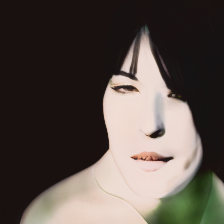

image 80/1500 | loss: 0.5911336541175842


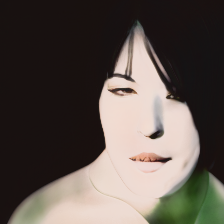

image 90/1500 | loss: 0.5859366655349731


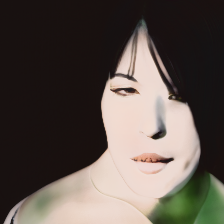

image 100/1500 | loss: 0.5782329440116882


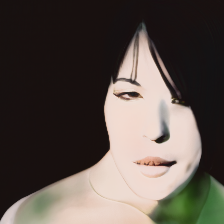

image 110/1500 | loss: 0.5809305906295776


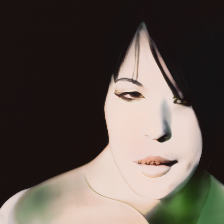

image 120/1500 | loss: 0.5895304679870605


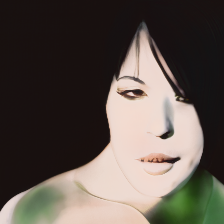

image 130/1500 | loss: 0.5790591239929199


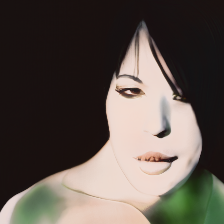

image 140/1500 | loss: 0.5723363161087036


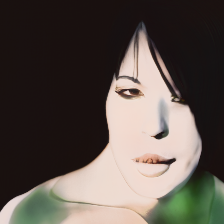

image 150/1500 | loss: 0.5638957023620605


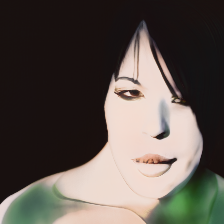

image 160/1500 | loss: 0.5819813013076782


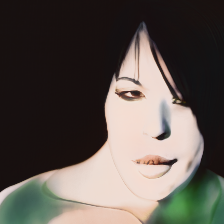

image 170/1500 | loss: 0.5757712125778198


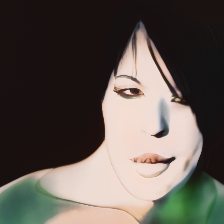

image 180/1500 | loss: 0.5607941150665283


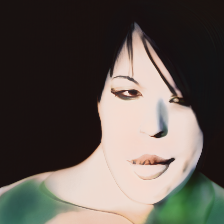

image 190/1500 | loss: 0.553244948387146


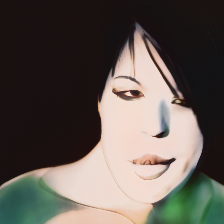

image 200/1500 | loss: 0.5601745247840881


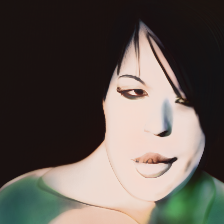

image 210/1500 | loss: 0.5754861831665039


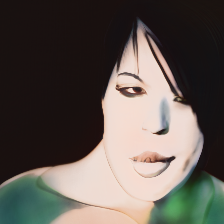

image 220/1500 | loss: 0.5588526725769043


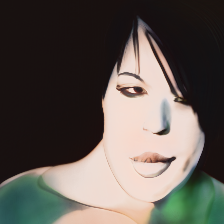

image 230/1500 | loss: 0.5453780889511108


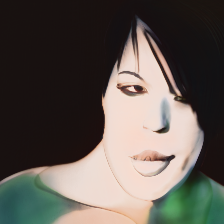

image 240/1500 | loss: 0.5519497394561768


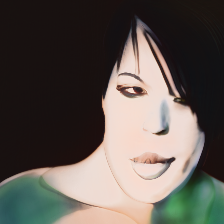

image 250/1500 | loss: 0.5377891063690186


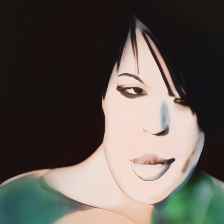

image 260/1500 | loss: 0.5435376763343811


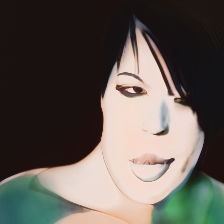

image 270/1500 | loss: 0.5438264608383179


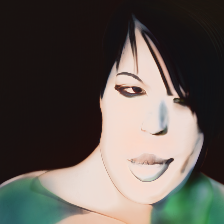

image 280/1500 | loss: 0.5381366014480591


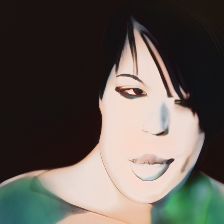

image 290/1500 | loss: 0.5208470821380615


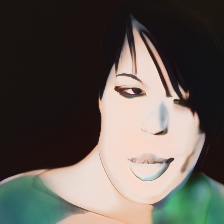

image 300/1500 | loss: 0.5615077614784241


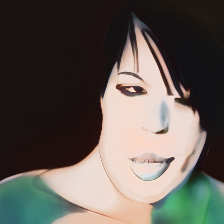

image 310/1500 | loss: 0.546790599822998


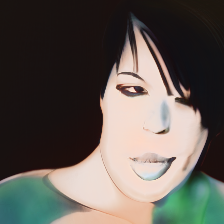

image 320/1500 | loss: 0.527856707572937


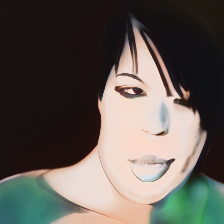

image 330/1500 | loss: 0.5237787961959839


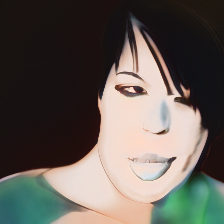

image 340/1500 | loss: 0.5245273113250732


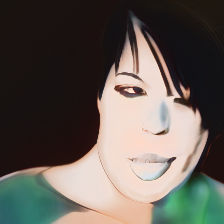

image 350/1500 | loss: 0.532522976398468


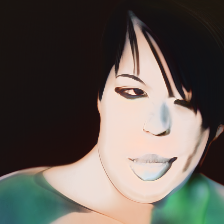

image 360/1500 | loss: 0.5241609811782837


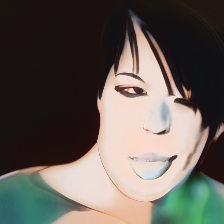

image 370/1500 | loss: 0.5167239904403687


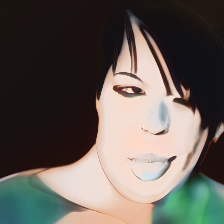

image 380/1500 | loss: 0.5340526103973389


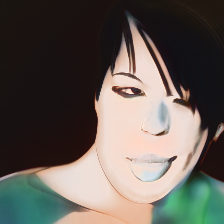

image 390/1500 | loss: 0.513149619102478


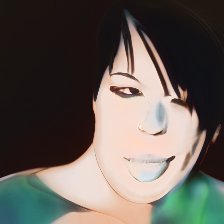

image 400/1500 | loss: 0.5402736663818359


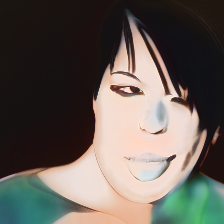

image 410/1500 | loss: 0.5238122344017029


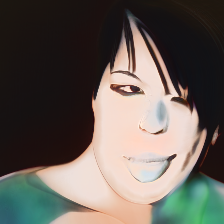

image 420/1500 | loss: 0.5144519805908203


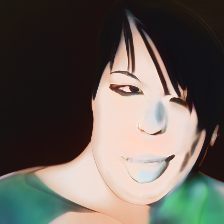

image 430/1500 | loss: 0.5067498683929443


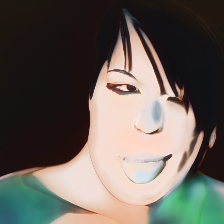

image 440/1500 | loss: 0.521735429763794


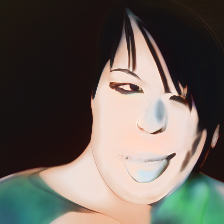

image 450/1500 | loss: 0.5177031755447388


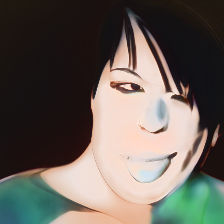

image 460/1500 | loss: 0.5227609872817993


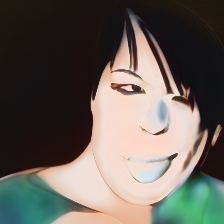

image 470/1500 | loss: 0.49385255575180054


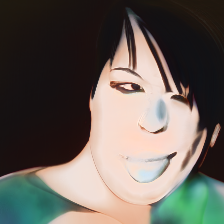

image 480/1500 | loss: 0.4940018951892853


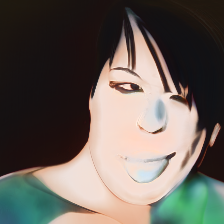

image 490/1500 | loss: 0.5098574161529541


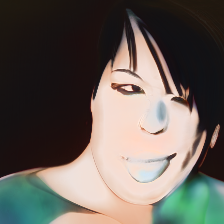

image 500/1500 | loss: 0.49120032787323


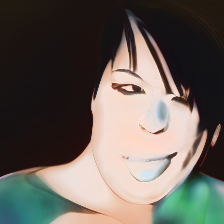

image 510/1500 | loss: 0.490500271320343


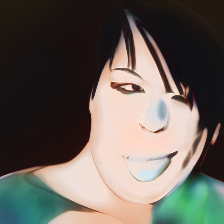

image 520/1500 | loss: 0.4964084029197693


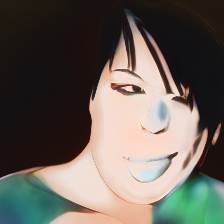

image 530/1500 | loss: 0.4914413392543793


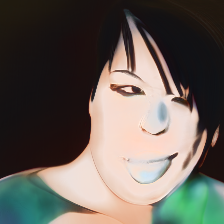

image 540/1500 | loss: 0.49616917967796326


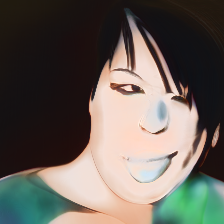

image 550/1500 | loss: 0.48770788311958313


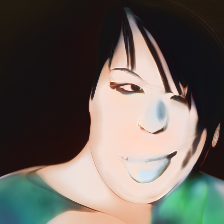

image 560/1500 | loss: 0.49144744873046875


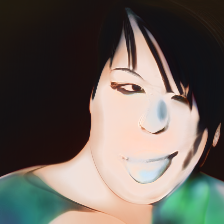

image 570/1500 | loss: 0.510640561580658


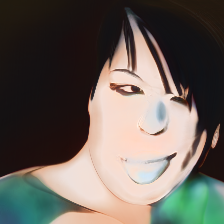

image 580/1500 | loss: 0.4898971617221832


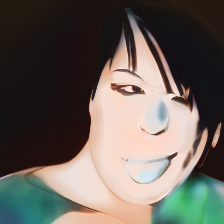

image 590/1500 | loss: 0.5015748739242554


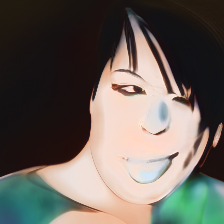

image 600/1500 | loss: 0.4795680046081543


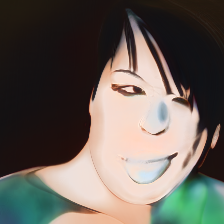

image 610/1500 | loss: 0.48476874828338623


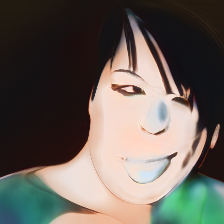

image 620/1500 | loss: 0.5062738060951233


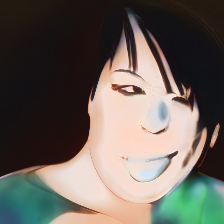

image 630/1500 | loss: 0.4911917448043823


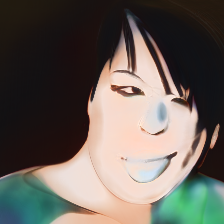

image 640/1500 | loss: 0.483012855052948


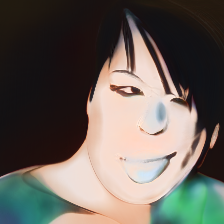

image 650/1500 | loss: 0.4983566105365753


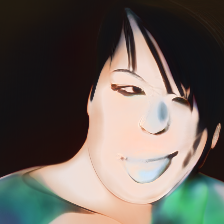

image 660/1500 | loss: 0.49422687292099


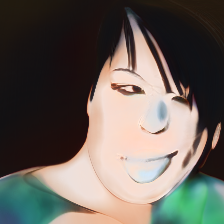

image 670/1500 | loss: 0.47914212942123413


In [9]:
#@markdown #**Run the inversion** 🚀

tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
])

seed = 14

def run(timestring, projection_target):
  torch.manual_seed(seed)

  target_features = get_target_features(projection_target)

  with torch.no_grad():
    qs = []
    losses = []
    for _ in range(8):
      q = (G.mapping(torch.randn([4,G.mapping.z_dim], device=device), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
      images = G.synthesis(q * w_stds + G.mapping.w_avg)
      loss = get_perceptual_loss(images, target_features)
      i = torch.argmin(loss)
      qs.append(q[i])
      losses.append(loss)
    qs = torch.stack(qs)
    losses = torch.stack(losses)
    i = torch.argmin(losses)
    q = qs[i].unsqueeze(0).requires_grad_()

  # Sampling loop
  q_ema = q
  opt = torch.optim.AdamW([q], lr=0.03, betas=(0.0,0.999))
  loop = tqdm(range(steps))
  for i in loop:
    opt.zero_grad()
    w = q * w_stds
    image = G.synthesis(w + G.mapping.w_avg, noise_mode='const')
    loss = get_perceptual_loss(image, target_features)
    loss.backward()
    opt.step()
    loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

    q_ema = q_ema * 0.9 + q * 0.1
    image = G.synthesis(q_ema * w_stds + G.mapping.w_avg, noise_mode='const')

    if i % 10 == 0:
      display(TF.to_pil_image(tf(image)[0]))
      print(f"image {i}/{steps} | loss: {loss}")
    pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
    os.makedirs(f'samples/{timestring}', exist_ok=True)
    pil_image.save(f'samples/{timestring}/{i:04}.jpg')

try:
  timestring = time.strftime('%Y%m%d%H%M%S')
  run(timestring, target_tensor)
except KeyboardInterrupt:
  pass